In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing

In [2]:
df = pd.read_csv("data/rain_outliers_removed.csv")
df.head()

,Season,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Summer,13.4,22.9,0.6,7.0,10.5,W,44,W,WNW,...,71,22,1007.7,1007.1,8,7,16.9,21.8,No,No
1,Summer,7.4,25.1,0.0,7.6,13.3,WNW,44,NNW,WSW,...,44,25,1010.6,1007.8,0,5,17.2,24.3,No,No
2,Summer,12.9,25.7,0.0,11.4,10.0,WSW,46,W,WSW,...,38,30,1007.6,1008.7,3,2,21.0,23.2,No,No
3,Summer,9.2,28.0,0.0,6.8,12.2,NE,24,SE,E,...,45,16,1017.6,1012.8,7,1,18.1,26.5,No,No
4,Summer,17.5,32.3,1.0,8.0,5.0,W,41,ENE,NW,...,82,33,1010.8,1006.0,7,8,17.8,29.7,No,No


In [3]:
# encoding RainTomorrow and RainToday as binary values
df.RainToday.replace(("Yes", "No"), (1,0), inplace = True)
df.RainTomorrow.replace(("Yes", "No"), (1,0), inplace = True)

In [4]:
le = preprocessing.LabelEncoder()

# encoding nominal attributes as labels - (Summer changes to 2, etc., will decode them later for readability, for classifiaction easier to go with numerical values)
# TODO: change this disgrace into one-hot encoding
df.Season = le.fit_transform(df.Season)
df.WindGustDir = le.fit_transform(df.WindGustDir)
df.WindDir9am = le.fit_transform(df.WindDir9am)
df.WindDir3pm = le.fit_transform(df.WindDir3pm)

df.head()

,Season,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2,13.4,22.9,0.6,7.0,10.5,13,44,13,14,...,71,22,1007.7,1007.1,8,7,16.9,21.8,0,0
1,2,7.4,25.1,0.0,7.6,13.3,14,44,6,15,...,44,25,1010.6,1007.8,0,5,17.2,24.3,0,0
2,2,12.9,25.7,0.0,11.4,10.0,15,46,13,15,...,38,30,1007.6,1008.7,3,2,21.0,23.2,0,0
3,2,9.2,28.0,0.0,6.8,12.2,4,24,9,0,...,45,16,1017.6,1012.8,7,1,18.1,26.5,0,0
4,2,17.5,32.3,1.0,8.0,5.0,13,41,1,7,...,82,33,1010.8,1006.0,7,8,17.8,29.7,0,0


/home/witold/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


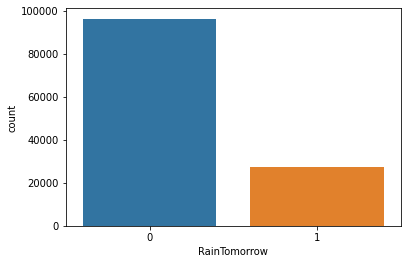

In [5]:
g = sns.countplot(df['RainTomorrow'])
plt.show()

I'm going to try under- and over- sampling here:

In [6]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

In [7]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)
print("Before undersampling: ", Counter(y_train))

Before undersampling:  Counter({0: 67483, 1: 19114})


In [9]:
undersample = RandomUnderSampler(sampling_strategy='majority')

X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

print("After undersampling: ", Counter(y_train_under))

After undersampling:  Counter({0: 19114, 1: 19114})


In [10]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score

model=SVC()
clf_under = model.fit(X_train_under, y_train_under)
pred_under = clf_under.predict(X_test)

print("ROC AUC score for undersampled data: ", roc_auc_score(y_test, pred_under))

ROC AUC score for undersampled data:  0.771733563506036
